## Policy gradient

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

Run a ChildNet architecture and obtain the reward

In [6]:
from childNet import ChildNet

layer_limit = 7 # max_layers

cn = ChildNet(layer_limit)
nb_epochs = 100

cn.compute_reward(['Tanh', 4, 1, 'ReLU', 8, 1], nb_epochs)

0.49000000953674316

Define the Policy Net and its loss (controller loss)

In [7]:
n_hidden = 24
possible_hidden_units = [1,2,4,8,16,32,'EOS']
encoded_eos = len(possible_hidden_units)
possible_act_functions = ['Sigmoid', 'Tanh', 'ReLU', 'LeakyReLU']
total_actions = possible_hidden_units + possible_act_functions
n_outputs = len(possible_hidden_units) + len(possible_act_functions)

batch_size = 15
learning_rate = 1e-2

class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_hidden, n_outputs, learning_rate, layer_limit):
        super(PolicyNet, self).__init__()
        
        self.layer_limit = layer_limit
        self.gamma = 1.0
        
        self.lstm = nn.LSTMCell(n_outputs, n_hidden)
        #self.lstm2 = nn.LSTMCell(n_hidden, n_hidden)
        self.layer_hid_un = nn.Linear(n_hidden, len(possible_hidden_units))
        self.layer_act_func = nn.Linear(n_hidden, len(possible_act_functions))
        self.linear = nn.Linear(n_hidden, n_outputs)
        
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def one_hot(self, t, num_classes):
        out = np.zeros((t.shape[0], num_classes))
        for row, col in enumerate(t):
            out[row, col] = 1
        return out.astype('float32')

    def sample_action(self, output, training):
        if training:
            random_array = np.random.rand(batch_size).reshape(batch_size,1)
            return (np.cumsum(output.detach().numpy(), axis=1) > random_array).argmax(axis=1) # sample action
        else: #eval
            return (output.detach().numpy()).argmax(axis=1)
                
    def forward(self, training):
        outputs = []
        prob = []
        actions = np.zeros((batch_size, self.layer_limit))
        action = not None #initialize action to don't break the while condition 
        i = 0
        counter_nb_layers = 0
        
        h_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        c_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        action = torch.zeros(batch_size, n_outputs, dtype=torch.float)

        #h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        #c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        
        while counter_nb_layers<self.layer_limit: 

            h_t, c_t = self.lstm(action, (h_t, c_t))
            
            #h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            
            output = F.softmax(self.linear(h_t))
            counter_nb_layers += 1
            action = self.sample_action(output, training)

            outputs += [output]
            prob.append(output[np.arange(batch_size),action])
            actions[:, i] = action
            action = torch.tensor(self.one_hot(action, n_outputs))            
            i += 1
            
        prob = torch.stack(prob, 1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        #outputs.view(-1, n_outputs)
        
        return prob, actions

    def loss(self, action_probabilities, returns, baseline):        
        #T is the number of hyperparameters 
        sum_over_T = torch.sum(torch.log(action_probabilities.view(batch_size, -1)), axis=1)
        subs_baseline = torch.add(returns,-baseline)
        return torch.mean(torch.mul(sum_over_T, subs_baseline)) - torch.sum(torch.mul (torch.tensor(0.01) * action_probabilities, torch.log(action_probabilities.view(batch_size, -1))))


Helper functions

In [8]:
def indexes_to_actions(actions):
    batch_hid_units = []
    batch_act_functions = []
    batch_index_eos = []
    
    for b in range(batch_size):
        batch_actions = actions[b,:]                
        hid_units = [total_actions[int(action)] for i,action in enumerate(batch_actions)]
        
        #cut when 'EOS' is reached
        try:
            index_eos = hid_units.index('EOS')
            hid_units = hid_units[:index_eos + 1]
        except ValueError:
            hid_units = hid_units[:-1] + ['EOS']
            index_eos = len(hid_units)
    
        batch_hid_units.append(hid_units)
        batch_index_eos.append(index_eos)
        
    return batch_hid_units, batch_index_eos
    
def fill_tensor(tensor_to_fill, size, ones=True):
    if len(tensor_to_fill.size()) >= 2: #dim >= 2
        tensor_to_fill = tensor_to_fill.view(-1)
    
    if ones:
        #fill with ones, useful if afterwards it will be applied log (log 1 = 0, log 0 = -inf)
        size_remaining = size - tensor_to_fill.size()[0]
        return torch.cat((tensor_to_fill, torch.ones(size_remaining)))
    else:        
        size_remaining = size - tensor_to_fill.size()[0]
        return torch.cat((tensor_to_fill, torch.zeros(size_remaining)))

Test Forward pass


In [9]:
policy = PolicyNet(n_hidden, n_outputs, learning_rate, layer_limit)
outputs, actions = policy(True)
outputs, actions, indexes_to_actions(actions)

/home/raul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(tensor([[0.1129, 0.0909, 0.0938, 0.0927, 0.0931, 0.1133, 0.0842],
         [0.0823, 0.0838, 0.0817, 0.0818, 0.0848, 0.0902, 0.1146],
         [0.0906, 0.0891, 0.0808, 0.1125, 0.0849, 0.1035, 0.0855],
         [0.0823, 0.0838, 0.0809, 0.0961, 0.1164, 0.0938, 0.0828],
         [0.0926, 0.0901, 0.0882, 0.0890, 0.0915, 0.0846, 0.0895],
         [0.0906, 0.0958, 0.0865, 0.0880, 0.1115, 0.0838, 0.1059],
         [0.0823, 0.0864, 0.0851, 0.1123, 0.1034, 0.1106, 0.0850],
         [0.0926, 0.0805, 0.0849, 0.1038, 0.1122, 0.0873, 0.0926],
         [0.1129, 0.1128, 0.0817, 0.0946, 0.1130, 0.1025, 0.1109],
         [0.0906, 0.0840, 0.0838, 0.0888, 0.0827, 0.0925, 0.0884],
         [0.0821, 0.0846, 0.1058, 0.0927, 0.0930, 0.1124, 0.0839],
         [0.1129, 0.0849, 0.0818, 0.0877, 0.0797, 0.0866, 0.0835],
         [0.0926, 0.0946, 0.1023, 0.0833, 0.0929, 0.1132, 0.0948],
         [0.0956, 0.0914, 0.0919, 0.0835, 0.0864, 0.0848, 0.1024],
         [0.0851, 0.0836, 0.0879, 0.0892, 0.0944, 0.0933, 0.09

Train the policy

In [11]:
# training settings

num_episodes = 500
decay = 0.9
verbose = False
# setup policy network

policy = PolicyNet(n_hidden, n_outputs, learning_rate, layer_limit)
baseline = torch.zeros(15, dtype=torch.float)

# train policy network

try:
    training_rewards, val_rewards, losses = [], [], []
    baseline = torch.zeros(15, dtype=torch.float)
    print('start training')
    for i in range(num_episodes):
        rollout, batch_r, batch_a_probs = [], [], []
        training = True
        with torch.no_grad():
            prob, actions = policy(training)
        batch_hid_units, batch_index_eos = indexes_to_actions(actions)
        for j in range(batch_size):
            # policy gradient update 
            if verbose:
                print(batch_hid_units[j])
            r = cn.compute_reward(batch_hid_units[j], nb_epochs)**3
            if batch_hid_units[j]==['EOS']:
                r -= -1
            a_probs = prob[j, :batch_index_eos[j] + 1]
            
            batch_r += [r]
            batch_a_probs += [a_probs.view(1, -1)] 
        
        a_probs = []
        for b in range(batch_size):
            a_probs.append(fill_tensor(batch_a_probs[b], n_outputs, ones=True))
        a_probs = torch.stack(a_probs,0)

        batch_a_probs = Variable(a_probs, requires_grad=True)
        batch_r = Variable(torch.tensor(batch_r), requires_grad=True)
        loss = policy.loss(batch_a_probs, batch_r, torch.mean(baseline))
        policy.optimizer.zero_grad()  
        loss.backward()
        policy.optimizer.step()
        
        # bookkeeping
        training_rewards.append(torch.mean(batch_r).detach().numpy())
        losses.append(loss.item())
        # actualize baseline
        baseline = torch.cat((baseline[1:]*decay, torch.tensor([torch.mean(batch_r)*(1-decay)], dtype=torch.float)))
        # print
        if verbose and (i+1) % val_freq == 0:
            print('{:4d}. mean training reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(losses[-val_freq:])))
            
        
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training


/home/raul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


done


Plot the training losses and the training rewards

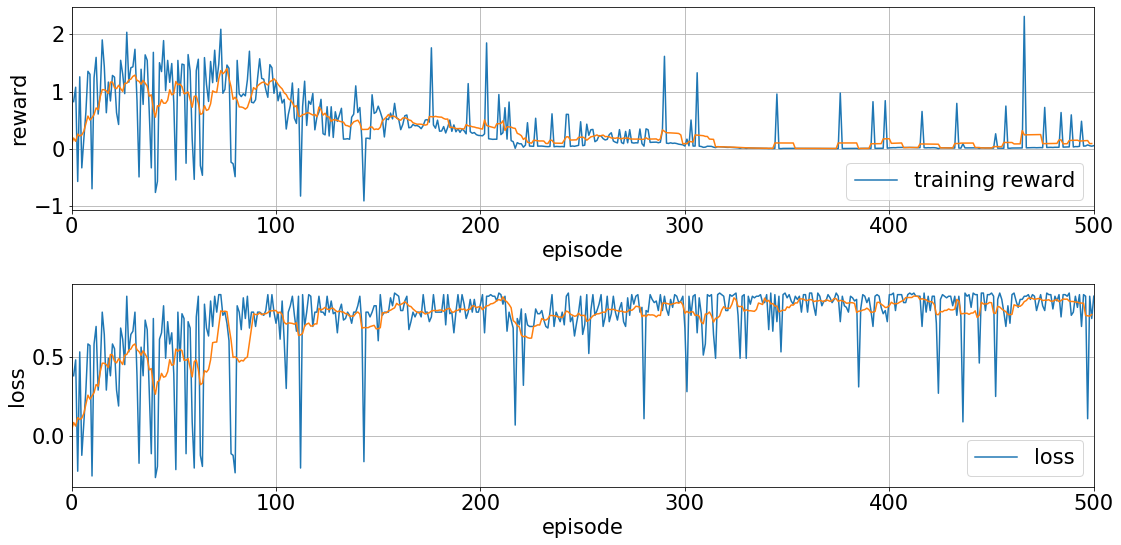

In [25]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})

# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))#, plt.ylim((-20,20))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); #plt.show()
plt.savefig('training.jpg')

Generate a childNet architecture and compute its reward

In [32]:
batch_hid_units, batch_index_eos = indexes_to_actions(policy(training)[1])
batch_hid_units[0], batch_index_eos[0]

([[8, 'ReLU', 4, 'Tanh', 4, 'ReLU', 'EOS']], [7])


/home/raul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
cn.compute_reward([8, 'ReLU', 4, 'Tanh', 4, 'ReLU', 'EOS'], nb_epochs)

0.96940023841858


In [35]:
torch.save(policy.state_dict(), 'policy.pt')